In [1]:
import sweetviz as sv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sweetviz\graph.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [2]:
df = pd.read_csv('da_internship_task_dataset.csv')
df = pd.DataFrame(df)

**Basic info**

In [3]:
print(df.info(), "\n")
print(df.describe(), "\n")
print(df.isnull().sum(), "\n")
print(df["uuid"].nunique(), "\n")  #unique values in uuid column
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uuid          122746 non-null  object 
 1   day_id        122746 non-null  object 
 2   license       122746 non-null  object 
 3   model         122746 non-null  object 
 4   feature       122746 non-null  object 
 5   requests_cnt  122746 non-null  float64
 6   spent_amount  122746 non-null  float64
dtypes: float64(2), object(5)
memory usage: 6.6+ MB
None 

        requests_cnt   spent_amount
count  122746.000000  122746.000000
mean       51.260742      12.227798
std       167.977380      37.588494
min         1.000000       0.270000
25%        18.000000       5.140000
50%        32.000000       8.020000
75%        54.000000      13.060000
max     12900.000000    2599.000000 

uuid            0
day_id          0
license         0
model           0
feature         0
requests_cnt    0
s

In [4]:
#sweetviz report
#report = sv.analyze(df)
#report.show_html('Sweetviz_Report_Pairwise.html')

**relationship between spent_amount and requests_cnt**

Correlation between requests_cnt and spent_amount: 0.9441770579957468


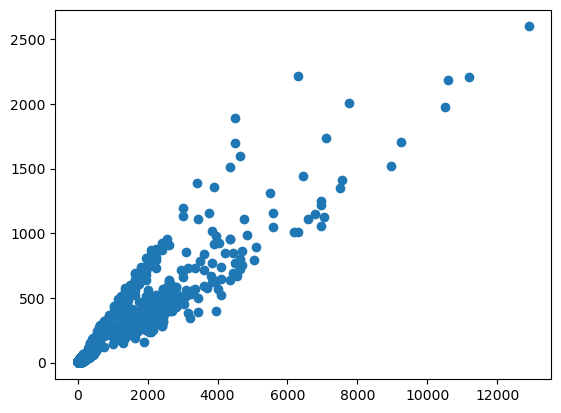

In [6]:
plt.scatter(df['requests_cnt'], df['spent_amount'])

#correlation 
correlation = np.corrcoef(df['requests_cnt'], df['spent_amount'])[0, 1]
print(f'Correlation between requests_cnt and spent_amount: {correlation}')

**user-based spent_amount and requests_cnt analysis**

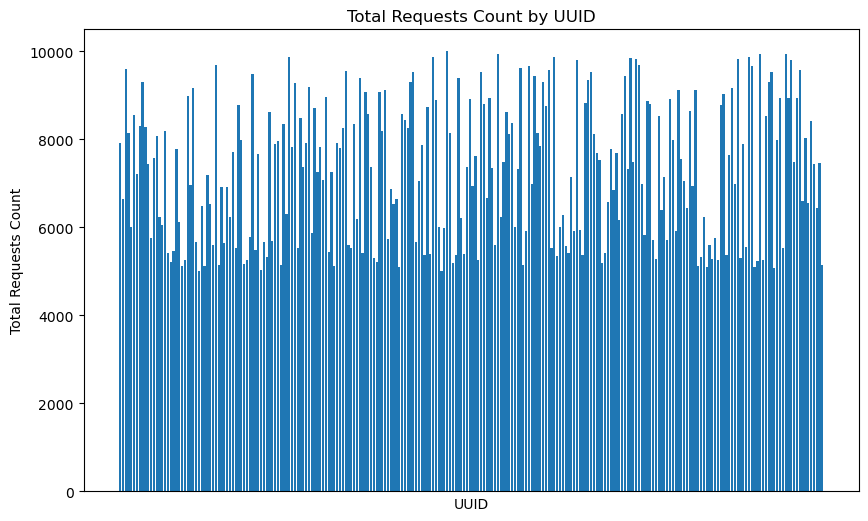

In [22]:
agg_df1 = df.groupby('uuid')['requests_cnt'].sum().reset_index()
agg_df1 = agg_df1[(agg_df1['requests_cnt'] > 5000) & (agg_df1['requests_cnt'] < 10000)]  #example threshold
plt.figure(figsize=(10,6))
plt.bar(agg_df1['uuid'], agg_df1['requests_cnt'])
plt.xlabel('UUID')
plt.ylabel('Total Requests Count')
plt.title('Total Requests Count by UUID')
plt.xticks(ticks =[])
plt.show()

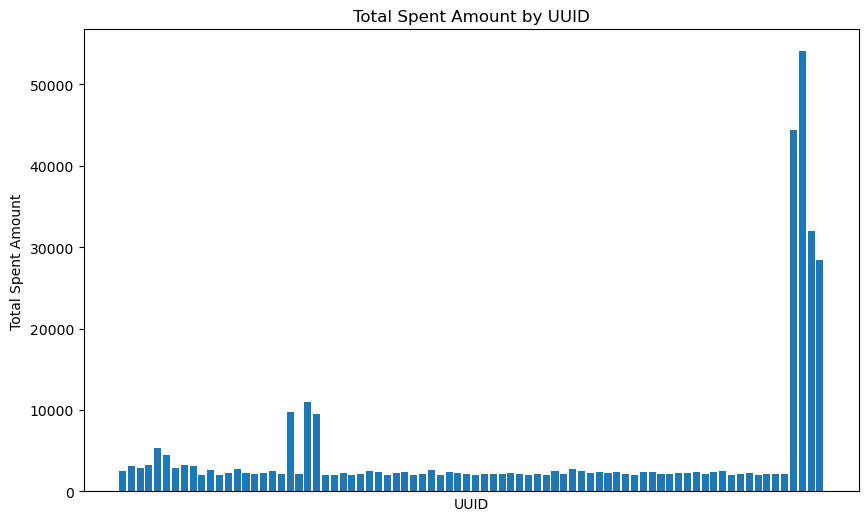

In [12]:
agg_df2 = df.groupby('uuid')['spent_amount'].sum().reset_index()
agg_df2 = agg_df2[agg_df2['spent_amount'] > 2000]  #example threshold, around 3000 is a good cut-off
plt.figure(figsize=(10,6))
plt.bar(agg_df2['uuid'], agg_df2['spent_amount'])
plt.xlabel('UUID')
plt.ylabel('Total Spent Amount')
plt.title('Total Spent Amount by UUID')
plt.xticks(ticks =[])
plt.show()

In [13]:
#outlier analysis - UUID with highest requests_cnt
max_requests_uuid = agg_df1.loc[agg_df1['requests_cnt'].idxmax()]
print(f'UUID with the highest number of requests: {max_requests_uuid["uuid"]} with {max_requests_uuid["requests_cnt"]} requests')

UUID with the highest number of requests: user_935 with 285050.0 requests


In [15]:
#outlier analysis - UUID with highest spent_amount
max_spent_uuid = agg_df2.loc[agg_df2['spent_amount'].idxmax()]
print(f'UUID with the highest spent amount: {max_spent_uuid["uuid"]} with {max_spent_uuid["spent_amount"]} spent amount')

UUID with the highest spent amount: user_935 with 54032.42 spent amount


In [16]:
#quantiles for spent_amount per uuid
agg_spent = df.groupby('uuid')['spent_amount'].sum().reset_index()
quantiles_spent = agg_spent['spent_amount'].quantile([0.5, 0.75, 0.9]).round()

print("Quantiles for total spent_amount per uuid:")
print(quantiles_spent)

#quantiles for requests_cnt per uuid
agg_requests = df.groupby('uuid')['requests_cnt'].sum().reset_index()
quantiles_requests = agg_requests['requests_cnt'].quantile([0.5, 0.75, 0.9]).round()

print("Quantiles for total requests_cnt per uuid:")
print(quantiles_requests)

Quantiles for total spent_amount per uuid:
0.50     521.0
0.75    1120.0
0.90    1674.0
Name: spent_amount, dtype: float64
Quantiles for total requests_cnt per uuid:
0.50    1986.0
0.75    4140.0
0.90    7890.0
Name: requests_cnt, dtype: float64


In [17]:
#user segmentation based on requests_cnt
agg_df2 = df.groupby('uuid')['requests_cnt'].sum().reset_index()

requests_cnt_bins = [0, 10000, 20000, np.inf] #thresholds based on a previous graph
labels = ['Low', 'Medium', 'High']

user_groups = pd.cut(agg_df2['requests_cnt'], bins=requests_cnt_bins, labels=labels, include_lowest=True)

group_counts = user_groups.value_counts().sort_index()

print("User segmentation based on requests_cnt:")
print(group_counts)

User segmentation based on requests_cnt:
requests_cnt
Low       1779
Medium      78
High         9
Name: count, dtype: int64


In [19]:
#user segmentation based on spent_amount
user_total_spent = df.groupby('uuid')['spent_amount'].sum().reset_index()

spent_amount_bins = [0, 2000, 3000, np.inf] #thresholds based on a previous graph
labels = ['Low', 'Medium', 'High']

user_groups = pd.cut(user_total_spent['spent_amount'], bins=spent_amount_bins, labels=labels, include_lowest=True)

group_counts = user_groups.value_counts().sort_index()

print("User segmentation based on spent_amount:")
print(group_counts)

User segmentation based on spent_amount:
spent_amount
Low       1786
Medium      67
High        13
Name: count, dtype: int64


In [23]:
#model usage distribution across user segments (based on requests_cnt)
user_total_requests = df.groupby('uuid')['requests_cnt'].sum()

labels = ['Low_Activity_User', 'Medium_Activity_User', 'High_Activity_User']

user_segments = pd.cut(user_total_requests, 
                    bins=requests_cnt_bins, 
                    labels=labels, 
                    include_lowest=True)

user_segments.name = 'user_segment'

df['user_segment'] = df['uuid'].map(user_segments)

model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()

model_segment_df.rename(columns={'uuid': 'unique_user_count'}, inplace=True)

print("Model usage distribution across user segments (based on requests_cnt):")
print(model_segment_df)

Model usage distribution across user segments (based on requests_cnt):
            user_segment    model  unique_user_count
0      Low_Activity_User  Model_A                816
1      Low_Activity_User  Model_B                596
2      Low_Activity_User  Model_C                598
3      Low_Activity_User  Model_D                649
4      Low_Activity_User  Model_E                423
5   Medium_Activity_User  Model_A                 21
6   Medium_Activity_User  Model_B                 13
7   Medium_Activity_User  Model_C                 41
8   Medium_Activity_User  Model_D                 53
9   Medium_Activity_User  Model_E                 17
10    High_Activity_User  Model_A                  6
11    High_Activity_User  Model_B                  1
12    High_Activity_User  Model_C                  5
13    High_Activity_User  Model_D                  3
14    High_Activity_User  Model_E                  1


C:\Users\Pc\AppData\Local\Temp\ipykernel_26592\3339114028.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()


In [24]:
#model usage distribution across user segments (based on spent_amount)
user_total_spent = df.groupby('uuid')['spent_amount'].sum()

labels = ['Low_Activity_User', 'Medium_Activity_User', 'High_Activity_User']

user_segments = pd.cut(user_total_spent, 
                    bins=spent_amount_bins, 
                    labels=labels, 
                    include_lowest=True)

user_segments.name = 'user_segment'

df['user_segment'] = df['uuid'].map(user_segments)

model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()

model_segment_df.rename(columns={'uuid': 'unique_user_count'}, inplace=True)

print("Model usage distribution across user segments (based on spent_amount):")
print(model_segment_df)

Model usage distribution across user segments (based on spent_amount):
            user_segment    model  unique_user_count
0      Low_Activity_User  Model_A                813
1      Low_Activity_User  Model_B                591
2      Low_Activity_User  Model_C                604
3      Low_Activity_User  Model_D                655
4      Low_Activity_User  Model_E                429
5   Medium_Activity_User  Model_A                 23
6   Medium_Activity_User  Model_B                 16
7   Medium_Activity_User  Model_C                 33
8   Medium_Activity_User  Model_D                 46
9   Medium_Activity_User  Model_E                 11
10    High_Activity_User  Model_A                  7
11    High_Activity_User  Model_B                  3
12    High_Activity_User  Model_C                  7
13    High_Activity_User  Model_D                  4
14    High_Activity_User  Model_E                  1


C:\Users\Pc\AppData\Local\Temp\ipykernel_26592\1549859170.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()


**Próba klasteryzacji**

C:\Users\Pc\AppData\Local\Temp\ipykernel_26592\3041172840.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_df['preferred_model'].fillna('Unknown', inplace=True)


--- Zagregowane dane na poziomie użytkownika ---
          total_requests  total_spent  avg_requests_per_day  \
uuid                                                          
user_1            7917.0      1538.96             71.972727   
user_10           4260.0       843.37             46.813187   
user_100          3628.0      1128.27             37.020408   
user_101          1880.0       624.96             23.209877   
user_102          3346.0       671.40             37.595506   

          unique_features_used preferred_model  
uuid                                            
user_1                       5         Model_E  
user_10                      5         Model_C  
user_100                     5         Model_A  
user_101                     5         Model_B  
user_102                     5         Model_D  
------------------------------ 

Dane przekształcone do macierzy o kształcie: (1866, 9)
------------------------------ 



c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there 

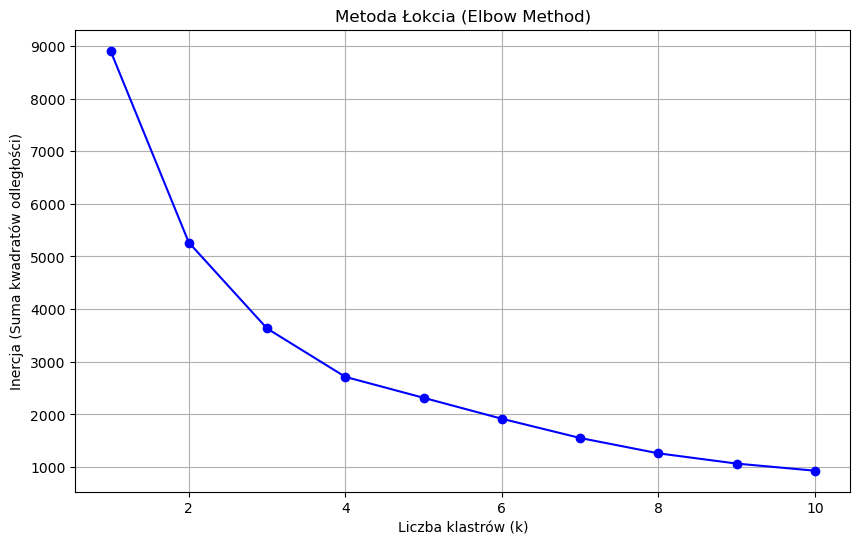

Przeanalizuj wykres Metody Łokcia, aby znaleźć 'zgięcie'.
W tym przykładzie wybierzemy k=4 jako optymalną liczbę.

--- Użytkownicy z przypisanymi klastrami ---
          total_requests  total_spent  avg_requests_per_day  \
uuid                                                          
user_1            7917.0      1538.96             71.972727   
user_10           4260.0       843.37             46.813187   
user_100          3628.0      1128.27             37.020408   
user_101          1880.0       624.96             23.209877   
user_102          3346.0       671.40             37.595506   

          unique_features_used preferred_model  cluster  
uuid                                                     
user_1                       5         Model_E        0  
user_10                      5         Model_C        0  
user_100                     5         Model_A        0  
user_101                     5         Model_B        0  
user_102                     5         Model_D    

c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


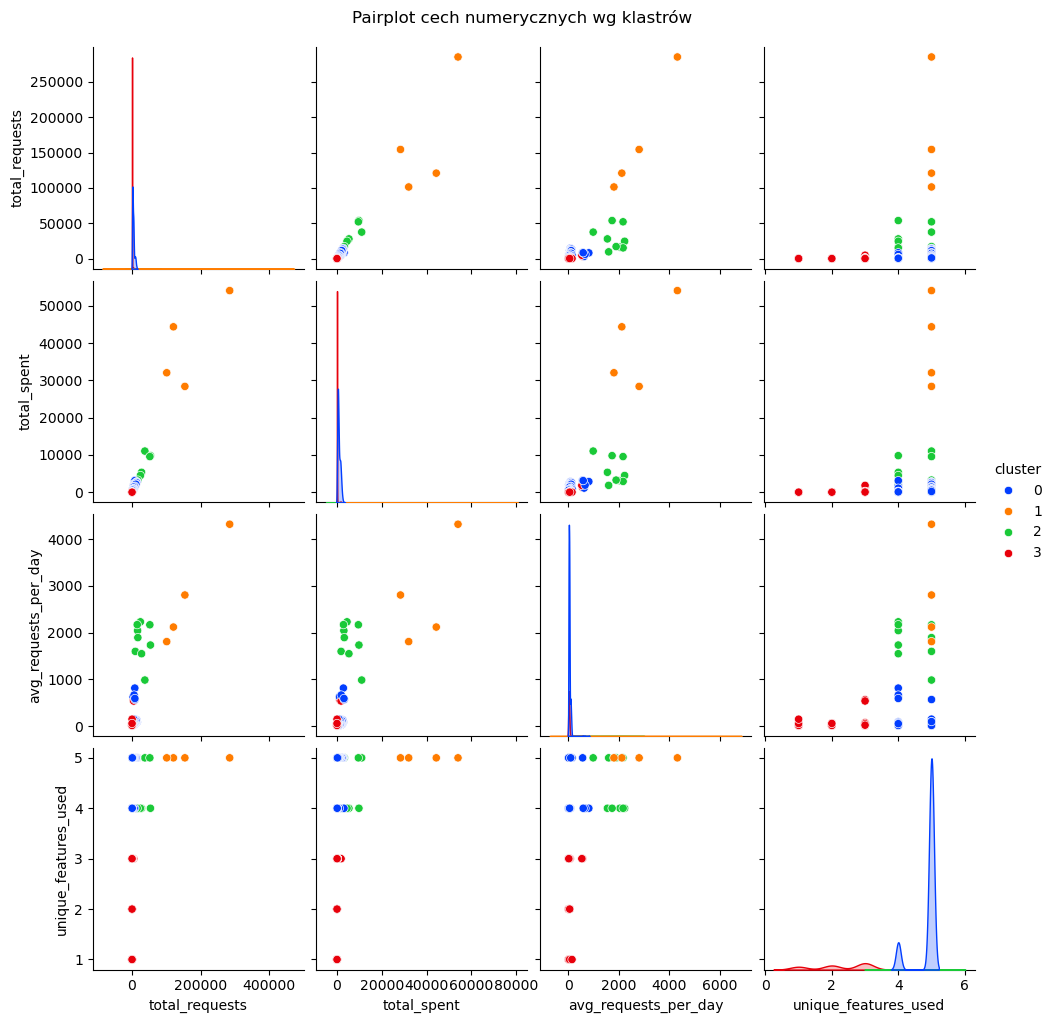

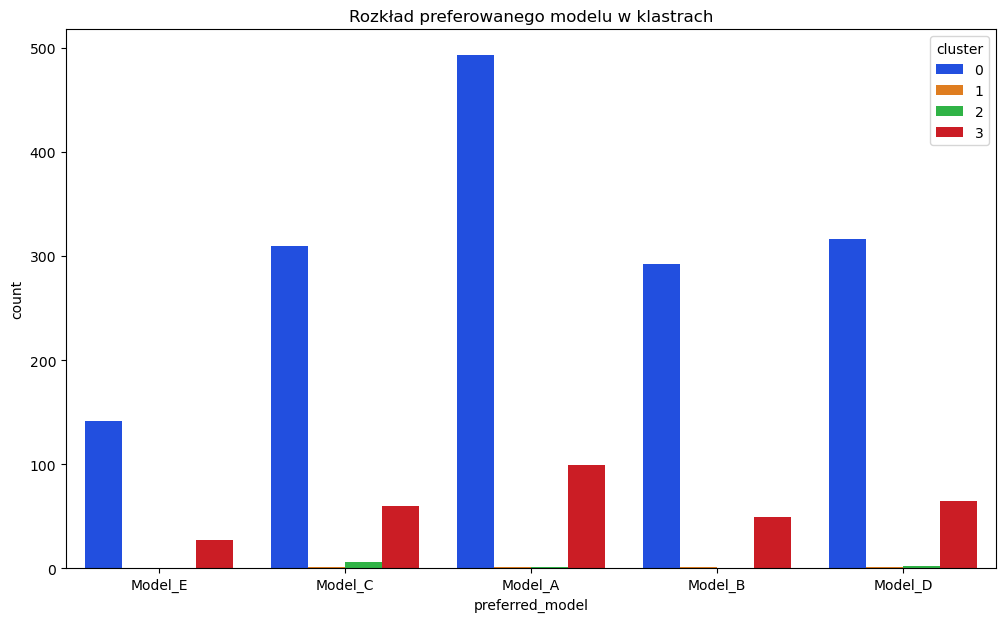

In [25]:
# === KROK 1: Agregacja danych na poziomie użytkownika (Feature Engineering) ===

# Agregujemy dane numeryczne
user_df = df.groupby('uuid').agg(
    total_requests=pd.NamedAgg(column='requests_cnt', aggfunc='sum'),
    total_spent=pd.NamedAgg(column='spent_amount', aggfunc='sum'),
    
    # Średnia liczba żądań w dniach aktywności (ponieważ df jest już na poziomie dnia)
    avg_requests_per_day=pd.NamedAgg(column='requests_cnt', aggfunc='mean'), 
    
    unique_features_used=pd.NamedAgg(column='feature', aggfunc='nunique')
)

# Agregujemy dane kategoryczne (dominujący model)
# Znajdujemy model z największą liczbą ŻĄDAŃ (nie tylko dni)
user_model_requests = df.groupby(['uuid', 'model'])['requests_cnt'].sum().reset_index()
idx = user_model_requests.groupby('uuid')['requests_cnt'].idxmax()
preferred_model = user_model_requests.loc[idx].set_index('uuid')['model']

# Łączymy wszystko w jedną ramkę danych na poziomie użytkownika
user_df = user_df.join(preferred_model.rename('preferred_model'))

# Obsługa ewentualnych braków danych (np. użytkownik bez żadnego modelu)
user_df['preferred_model'].fillna('Unknown', inplace=True)

print("--- Zagregowane dane na poziomie użytkownika ---")
print(user_df.head())
print("-" * 30, "\n")


# === KROK 2: Preprocessing (Normalizacja i Kodowanie) ===

# Identyfikujemy kolumny numeryczne i kategoryczne
numeric_features = ['total_requests', 'total_spent', 'avg_requests_per_day', 'unique_features_used']
categorical_features = ['preferred_model']

# Tworzymy pipeline'y do transformacji
# Dla danych numerycznych: Uzupełnij braki (jeśli są) i skaluj
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Na wypadek braków danych
    ('scaler', StandardScaler())                  # Normalizacja
])

# Dla danych kategorycznych: Uzupełnij braki i zakoduj (OneHotEncoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Na wypadek braków danych
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Tworzy kolumny 0/1
])

# Łączymy oba pipeline'y za pomocą ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Stosujemy preprocessing
# X_processed to teraz numpy array gotowa do klastrowania
X_processed = preprocessor.fit_transform(user_df)

print(f"Dane przekształcone do macierzy o kształcie: {X_processed.shape}")
print("-" * 30, "\n")


# === KROK 3: Znalezienie optymalnej liczby klastrów (Metoda Łokcia) ===

inertia = []
K_range = range(1, 11) # Sprawdzimy od 1 do 10 klastrów

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

# Wykres Metody Łokcia
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inercja (Suma kwadratów odległości)')
plt.title('Metoda Łokcia (Elbow Method)')
plt.grid(True)
plt.show()

print("Przeanalizuj wykres Metody Łokcia, aby znaleźć 'zgięcie'.\n"
      "W tym przykładzie wybierzemy k=4 jako optymalną liczbę.\n")

# === KROK 4: Uruchomienie finalnego modelu K-Means ===

# Ustawiamy k na podstawie analizy "łokcia" (np. k=4)
OPTIMAL_K = 4 

kmeans = KMeans(n_clusters=OPTIMAL_K, n_init=10, random_state=42)
kmeans.fit(X_processed)

# Przypisanie etykiet klastrów z powrotem do ramki danych
user_df['cluster'] = kmeans.labels_

print("--- Użytkownicy z przypisanymi klastrami ---")
print(user_df.head())
print("-" * 30, "\n")


# === KROK 5: Analiza i Interpretacja Klastrów (Tworzenie Person) ===

# Obliczamy średnie wartości cech numerycznych dla każdego klastra
cluster_analysis_numeric = user_df.groupby('cluster')[numeric_features].mean()

# Obliczamy rozkład cech kategorycznych dla każdego klastra
cluster_analysis_categorical = user_df.groupby('cluster')['preferred_model'].value_counts(normalize=True).unstack().fillna(0)

# Obliczamy liczność każdego klastra
cluster_size = user_df['cluster'].value_counts().sort_index().to_frame(name='cluster_size')

# Łączymy wyniki analizy
cluster_profile = pd.concat([cluster_size, cluster_analysis_numeric, cluster_analysis_categorical], axis=1)

print("--- PROFIL KLASTRA (ŚREDNIE WARTOŚCI) ---")
# Transponujemy (T) dla łatwiejszego czytania
print(cluster_profile.T)
print("-" * 30, "\n")

# --- Interpretacja (Przykładowe Persony) ---
# Na podstawie powyższej tabeli (cluster_profile) możesz nazwać swoje klastry:
#
# * Klaster 0 ("Power Users"): Może mieć najwyższe 'total_spent' i 'total_requests',
#     używa wielu 'unique_features' i preferuje 'model_C' (ten drogi).
#
# * Klaster 1 ("Oszczędni Regularni"): Średnie 'total_requests', ale niskie 'total_spent',
#     preferują 'model_A' (ten tani).
#
# * Klaster 2 ("Nowicjusze / Testerzy"): Niskie wszystko: 'total_requests', 'total_spent',
#     'avg_requests_per_day', niska liczba 'unique_features'.
#
# * Klaster 3 ("Specjaliści od Funkcji Y"): Średnie wydatki, ale bardzo wysokie 
#     'avg_requests_per_day' i 100% preferencji dla 'model_B'.
# --------------------------------------------------

# === KROK 6: Wizualizacja (Opcjonalnie, ale bardzo polecane) ===

# Używamy `pairplot` do zwizualizowania relacji między cechami, kolorując wg klastra
# Wybieramy tylko cechy numeryczne, bo na nich widać zależności
print("Generowanie wizualizacji Pairplot (może chwilę potrwać)...")
sns.pairplot(user_df, hue='cluster', vars=numeric_features, palette='bright')
plt.suptitle('Pairplot cech numerycznych wg klastrów', y=1.02)
plt.show()

# Wizualizacja preferowanego modelu
plt.figure(figsize=(12, 7))
sns.countplot(data=user_df, x='preferred_model', hue='cluster', palette='bright')
plt.title('Rozkład preferowanego modelu w klastrach')
plt.show()

**Model-based analysis**

**Spent amount per model**

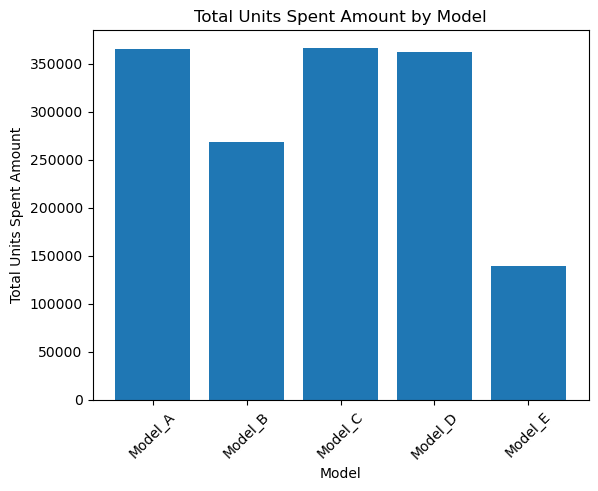

In [26]:
agg_df = df.groupby('model')['spent_amount'].sum().reset_index()
plt.bar(agg_df['model'], agg_df['spent_amount'])
plt.xlabel('Model')
plt.ylabel('Total Units Spent Amount')
plt.title('Total Units Spent Amount by Model')
plt.xticks(rotation=45)
plt.show()

In [27]:
#porównanie ilości użyć danego modelu w zależności od używanej licencji (kolumna license)
#z posdziałem na bloki w zależności od license (posortowane malejąco według requests_cnt)

license_usage = df.groupby(['model', 'license'])['requests_cnt'].sum().reset_index()
license_usage = license_usage.sort_values(by='requests_cnt', ascending=False)
for i in range(len(df['license'].unique())):
    license_block = license_usage[license_usage['license'] == df['license'].unique()[i]]
    print(license_block)

      model  license  requests_cnt
10  Model_C  Premium      676182.0
14  Model_D  Premium      406016.0
2   Model_A  Premium      258014.0
18  Model_E  Premium      206760.0
6   Model_B  Premium      172656.0
      model license  requests_cnt
8   Model_C   Basic      366564.0
12  Model_D   Basic      333519.0
0   Model_A   Basic      181463.0
4   Model_B   Basic      104788.0
16  Model_E   Basic       91789.0
      model     license  requests_cnt
13  Model_D  Enterprise      548537.0
9   Model_C  Enterprise      498204.0
1   Model_A  Enterprise      309526.0
5   Model_B  Enterprise      294919.0
17  Model_E  Enterprise      274188.0
      model   license  requests_cnt
15  Model_D  Standard      606078.0
11  Model_C  Standard      400846.0
3   Model_A  Standard      242930.0
19  Model_E  Standard      161064.0
7   Model_B  Standard      158008.0


In [28]:
#średnia spent_amount per model
model_usage = df.groupby('model')['spent_amount'].mean().reset_index()
print(model_usage)

     model  spent_amount
0  Model_A      9.596685
1  Model_B     11.603898
2  Model_C     15.005187
3  Model_D     14.806012
4  Model_E     10.946868


In [29]:
#porównanie ilości użyć danego modelu dla różnych wartości z kolumny feature (posortowane malejąco według requests_cnt)
feature_usage = df.groupby(['model', 'feature'])['requests_cnt'].sum().reset_index()
feature_usage = feature_usage.sort_values(by='requests_cnt', ascending=False)
print(feature_usage)

      model    feature  requests_cnt
10  Model_C  Feature_1      937253.0
15  Model_D  Feature_1      798043.0
16  Model_D  Feature_2      603601.0
11  Model_C  Feature_2      404161.0
0   Model_A  Feature_1      363290.0
12  Model_C  Feature_3      358344.0
20  Model_E  Feature_1      329741.0
1   Model_A  Feature_2      295124.0
6   Model_B  Feature_2      252778.0
17  Model_D  Feature_3      251417.0
5   Model_B  Feature_1      241452.0
2   Model_A  Feature_3      231346.0
21  Model_E  Feature_2      200811.0
7   Model_B  Feature_3      184196.0
13  Model_C  Feature_4      162050.0
18  Model_D  Feature_4      124580.0
19  Model_D  Feature_5      116509.0
22  Model_E  Feature_3      110376.0
14  Model_C  Feature_5       79988.0
3   Model_A  Feature_4       69566.0
23  Model_E  Feature_4       52162.0
24  Model_E  Feature_5       40711.0
9   Model_B  Feature_5       35448.0
4   Model_A  Feature_5       32607.0
8   Model_B  Feature_4       16497.0


**Retension Analysis**

In [ ]:
# Analysis of retention rate of uuid based on requests_cnt and spent_amount

def calculate_retention_metrics(df):
    retention_requests = df[df['requests_cnt'] > 0].shape[0] / df.shape[0]
    retention_spent = df[df['spent_amount'] > 0].shape[0] / df.shape[0]
    return retention_requests, retention_spent
    
user_retention = df.groupby('uuid').apply(calculate_retention_metrics).reset_index()

# Split the tuple into two separate columns
user_retention[['retention_requests', 'retention_spent']] = pd.DataFrame(user_retention[0].tolist(), index=user_retention.index)
user_retention = user_retention.drop(columns=[0])
print(user_retention.head())

#mean retention rates
mean_retention_requests = user_retention['retention_requests'].mean()
mean_retention_spent = user_retention['retention_spent'].mean()
print(f'Mean Retention Rate based on Requests Count: {mean_retention_requests}')
print(f'Mean Retention Rate based on Spent Amount: {mean_retention_spent}')



       uuid  retention_requests  retention_spent
0    user_1                 1.0              1.0
1   user_10                 1.0              1.0
2  user_100                 1.0              1.0
3  user_101                 1.0              1.0
4  user_102                 1.0              1.0
Mean Retention Rate based on Requests Count: 1.0
Mean Retention Rate based on Spent Amount: 1.0


C:\Users\Pc\AppData\Local\Temp\ipykernel_20444\2767514790.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_retention = df.groupby('uuid').apply(calculate_retention_metrics).reset_index()


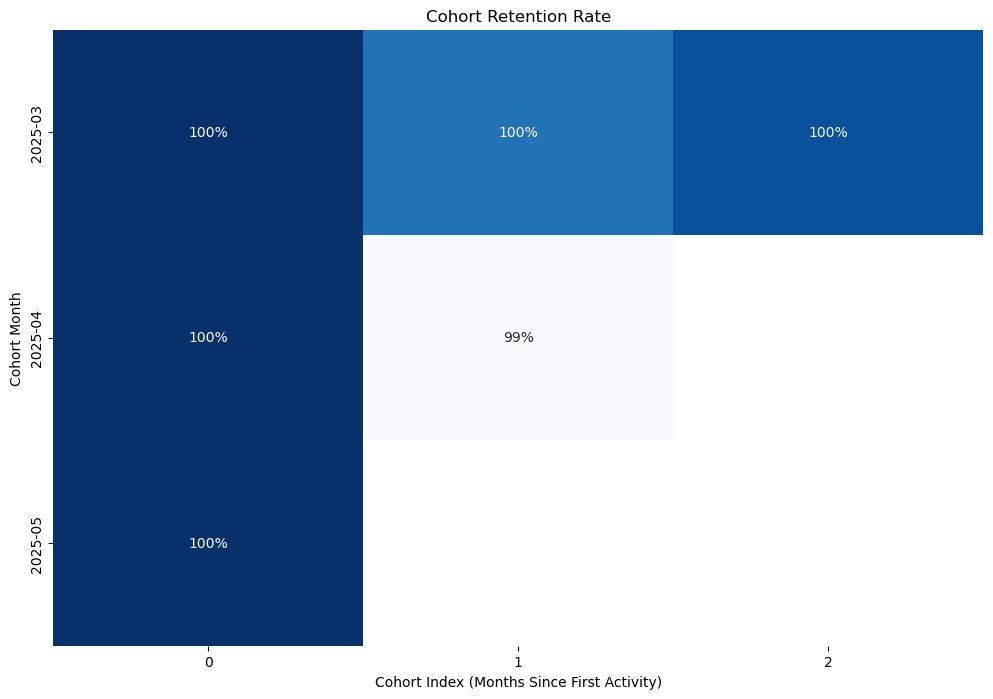

In [21]:
#cohort analysis
from operator import attrgetter


df['date'] = pd.to_datetime(df['day_id'], format='%Y-%m-%d')
df['cohort_month'] = df.groupby('uuid')['date'].transform('min').dt.to_period('M')
df['activity_month'] = df['date'].dt.to_period('M')
cohort_data = df.groupby(['cohort_month', 'activity_month']).agg(
    total_users=('uuid', 'nunique'),
    active_users=('uuid', lambda x: x.nunique())
).reset_index()
cohort_data['cohort_index'] = (cohort_data['activity_month'] - cohort_data['cohort_month']).apply(attrgetter('n'))
cohort_pivot = cohort_data.pivot_table(index='cohort_month', columns='cohort_index', values='active_users')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues', cbar=False)
plt.title('Cohort Retention Rate')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index (Months Since First Activity)')
plt.show()



**cost per request analysis**

Average Cost per Request: 0.2791191809742142
Cost per Request by Model:
     model  cost_per_request
0  Model_A          0.369166
1  Model_B          0.366373
2  Model_C          0.189598
3  Model_D          0.192177
4  Model_E          0.190301
Cost per Request by Feature:
     feature  cost_per_request
0  Feature_1          0.275974
1  Feature_2          0.280180
2  Feature_3          0.282840
3  Feature_4          0.276937
4  Feature_5          0.282122
Cost per Request by License:
      license  cost_per_request
0       Basic          0.278792
1  Enterprise          0.277053
2     Premium          0.276352
3    Standard          0.282439


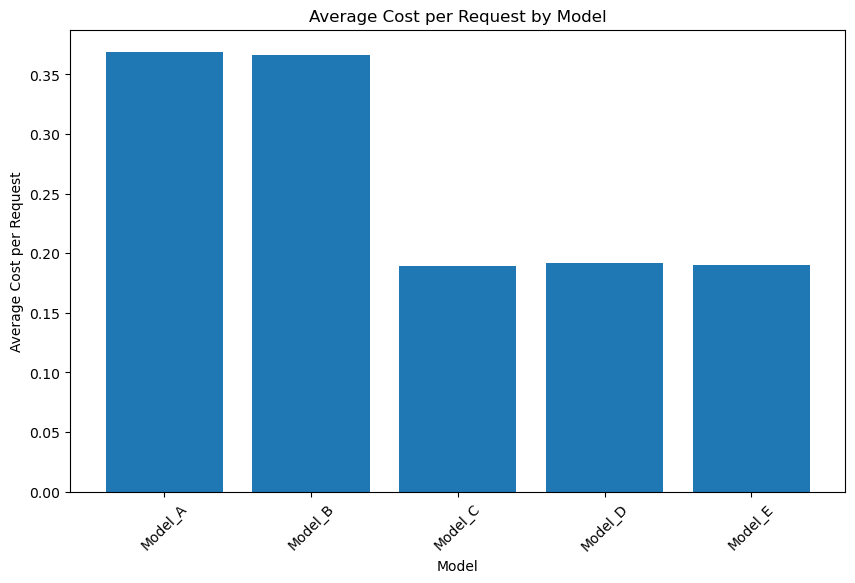

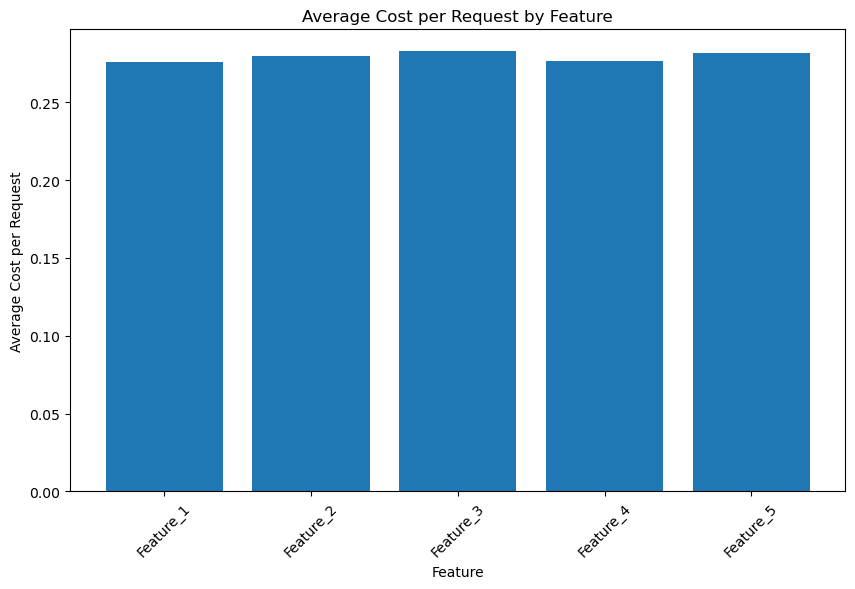

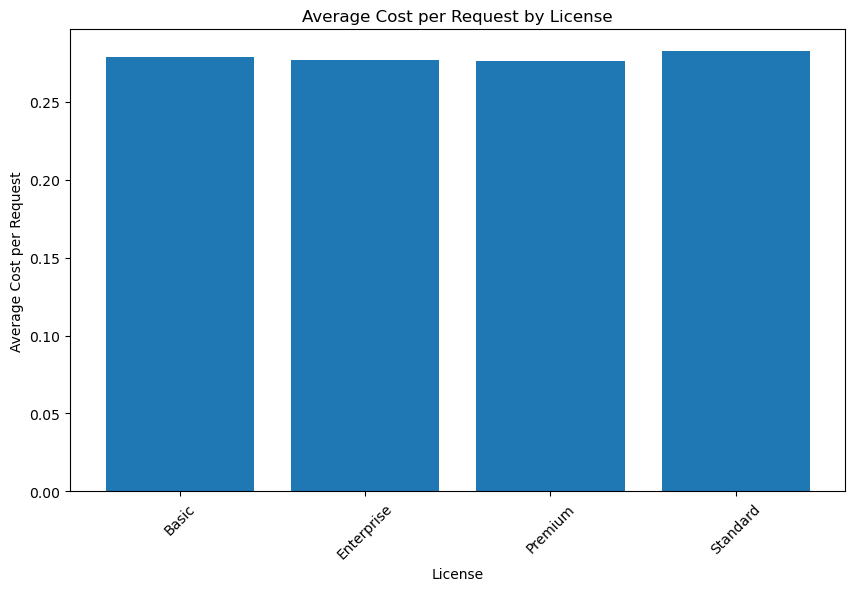

In [ ]:
df['cost_per_request'] = df.apply(lambda row: row['spent_amount'] / row['requests_cnt'] if row['requests_cnt'] > 0 else 0, axis=1)
avg_cost_per_request = df['cost_per_request'].mean()
print(f'Average Cost per Request: {avg_cost_per_request}')

#cost per request by model
model_cost_per_request = df.groupby('model')['cost_per_request'].mean().reset_index()
print("Cost per Request by Model:")
print(model_cost_per_request)

#cost per request by feature
feature_cost_per_request = df.groupby('feature')['cost_per_request'].mean().reset_index()
print("Cost per Request by Feature:")
print(feature_cost_per_request)

#cost per request by license
license_cost_per_request = df.groupby('license')['cost_per_request'].mean().reset_index()
print("Cost per Request by License:")
print(license_cost_per_request)

#visualization of cost per request by model
plt.figure(figsize=(10,6))
plt.bar(model_cost_per_request['model'], model_cost_per_request['cost_per_request'])
plt.xlabel('Model')
plt.ylabel('Average Cost per Request')
plt.title('Average Cost per Request by Model')
plt.xticks(rotation=45)
plt.show()

#visualization of cost per request by feature
plt.figure(figsize=(10,6))
plt.bar(feature_cost_per_request['feature'], feature_cost_per_request['cost_per_request'])
plt.xlabel('Feature')
plt.ylabel('Average Cost per Request')
plt.title('Average Cost per Request by Feature')
plt.xticks(rotation=45)
plt.show()

#visualization of cost per request by license
plt.figure(figsize=(10,6))
plt.bar(license_cost_per_request['license'], license_cost_per_request['cost_per_request'])
plt.xlabel('License')
plt.ylabel('Average Cost per Request')
plt.title('Average Cost per Request by License')
plt.xticks(rotation=45)
plt.show()

**user journey**

--- Dominujący model per użytkownik/miesiąc (fragment) ---
          uuid  month    model  requests_cnt
8316  user_935      5  Model_C      150550.0
8314  user_935      4  Model_C      102500.0
8325  user_937      5  Model_D       80950.0
8323  user_937      4  Model_D       68950.0
8309  user_933      5  Model_B       59300.0
------------------------------ 

--- Tabela podróży użytkownika (fragment) ---
month    March_Model April_Model May_Model
uuid                                      
user_1       Model_E     Model_E   Model_E
user_10      Model_C     Model_C   Model_C
user_100     Model_A     Model_A   Model_A
user_101     Model_B     Model_B   Model_B
user_102     Model_D     Model_D   Model_D
------------------------------ 

--- MACIERZ MIGRACJI (Marzec -> Maj) ---
May_Model    Model_A  Model_B  Model_C  Model_D  Model_E
March_Model                                             
Model_A          456        0        0        3        1
Model_B            0      275        0        

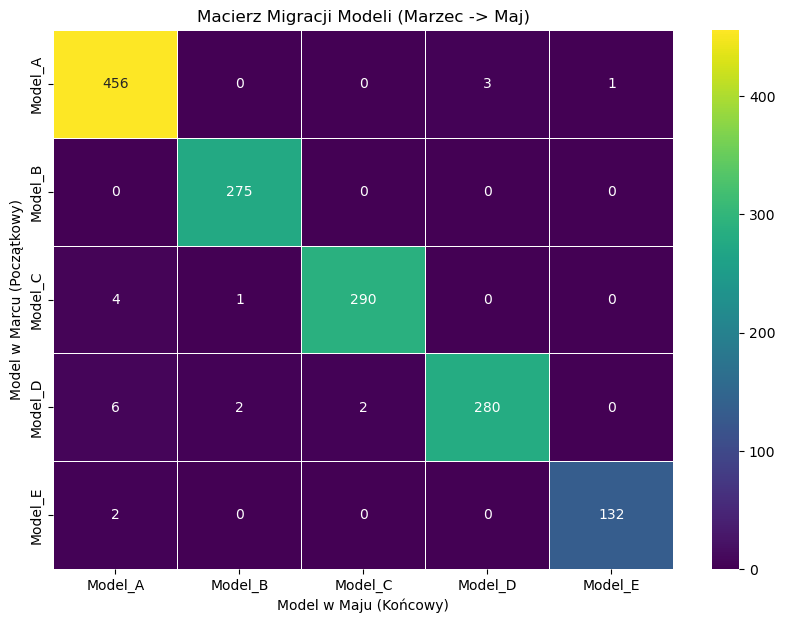

--- Podsumowanie progresji użytkowników (Marzec -> Maj) ---
Progression_Type
No Change    100.0
Name: proportion, dtype: float64




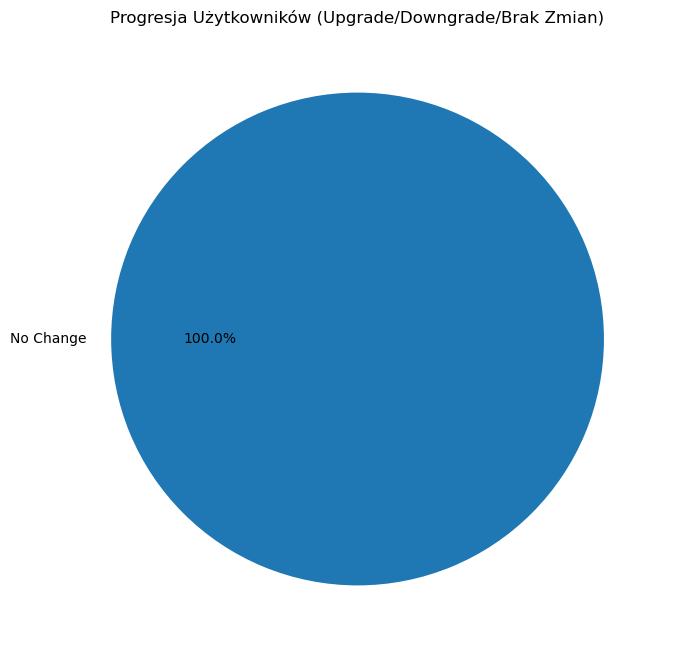

In [34]:


# --- Krok 1: Przygotowanie danych ---

# Zakładamy, że 'df' jest już wczytany
# Upewnij się, że 'day_id' jest w formacie datetime
df['day_id'] = pd.to_datetime(df['day_id'])

# Wyodrębnij miesiąc (jako liczbę: 3, 4, 5)
df['month'] = df['day_id'].dt.month

# --- Krok 2: Znalezienie dominującego modelu dla każdego użytkownika w każdym miesiącu ---

# Chcemy wiedzieć, którego modelu użytkownik używał NAJCZĘŚCIEJ (wg liczby żądań)
# 1. Zlicz sumę żądań dla każdej kombinacji użytkownik-miesiąc-model
monthly_usage = df.groupby(['uuid', 'month', 'model'])['requests_cnt'].sum().reset_index()

# 2. Posortuj, aby znaleźć model z największą liczbą żądań
monthly_usage_sorted = monthly_usage.sort_values(by='requests_cnt', ascending=False)

# 3. Usuń duplikaty, zachowując tylko pierwszy wpis (ten z max 'requests_cnt')
# To jest nasz "preferowany" model dla danego miesiąca
dominant_model = monthly_usage_sorted.drop_duplicates(subset=['uuid', 'month'], keep='first')

print("--- Dominujący model per użytkownik/miesiąc (fragment) ---")
print(dominant_model.head())
print("-" * 30, "\n")

# --- Krok 3: Stworzenie tabeli przestawnej (Pivot) do śledzenia podróży ---

# Chcemy, aby użytkownicy byli w wierszach, a miesiące w kolumnach
journey_pivot = dominant_model.pivot(index='uuid', 
                                     columns='month', 
                                     values='model')

# Zmieńmy nazwy kolumn dla czytelności
journey_pivot = journey_pivot.rename(columns={
    3: 'March_Model',
    4: 'April_Model',
    5: 'May_Model'
})

print("--- Tabela podróży użytkownika (fragment) ---")
print(journey_pivot.head())
print("-" * 30, "\n")

# --- Krok 4: Analiza "przesiadki" (Marzec vs Maj) ---

# Skupmy się na kohorcie użytkowników, którzy byli aktywni ZARÓWNO w marcu, jak i w maju
# Usuwamy użytkowników, którzy nie byli aktywni w obu tych miesiącach
cohort_df = journey_pivot[['March_Model', 'May_Model']].dropna()

# Stwórz macierz migracji (Crosstabulation)
# To jest sedno odpowiedzi na Twoje pytanie
migration_matrix = pd.crosstab(
    cohort_df['March_Model'],  # Wiersze: Skąd przyszli (Model w Marcu)
    cohort_df['May_Model']     # Kolumny: Dokąd poszli (Model w Maju)
)

print("--- MACIERZ MIGRACJI (Marzec -> Maj) ---")
print(migration_matrix)
print("\nOpis: Wiersze to model w Marcu, Kolumny to model w Maju.\n")

# --- Krok 5: Wizualizacja macierzy migracji (Heatmap) ---

plt.figure(figsize=(10, 7))
sns.heatmap(migration_matrix, 
            annot=True,     # Pokaż liczby w komórkach
            fmt='d',        # Formatuj jako liczby całkowite
            cmap='viridis', # Schemat kolorów
            linewidths=.5)
plt.title('Macierz Migracji Modeli (Marzec -> Maj)')
plt.ylabel('Model w Marcu (Początkowy)')
plt.xlabel('Model w Maju (Końcowy)')
plt.show()

# --- Krok 6: Ilościowe określenie "Upgrade'u" ---

# Załóżmy hierarchię kosztów: model_A (tani) < model_B (średni) < model_C (drogi)
# Jeśli nie masz pewności, możesz ją wywnioskować z analizy 'cost_per_request'
model_hierarchy = {
    'model_A': 1,  # Przykładowy tani model
    'model_B': 2,  # Przykładowy średni model
    'model_C': 3   # Przykładowy drogi model
}

# Zmapuj rangi do naszej kohorty
cohort_df['March_Rank'] = cohort_df['March_Model'].map(model_hierarchy)
cohort_df['May_Rank'] = cohort_df['May_Model'].map(model_hierarchy)

# Oblicz zmianę
cohort_df['Progression'] = cohort_df['May_Rank'] - cohort_df['March_Rank']

# Zdefiniuj typy progresji
def categorize_progression(change):
    if change > 0:
        return 'Upgrade'
    elif change < 0:
        return 'Downgrade'
    else:
        return 'No Change'

cohort_df['Progression_Type'] = cohort_df['Progression'].apply(categorize_progression)

# Pokaż podsumowanie
progression_summary = cohort_df['Progression_Type'].value_counts(normalize=True) * 100

print("--- Podsumowanie progresji użytkowników (Marzec -> Maj) ---")
print(progression_summary)
print("\n")

# Wizualizacja podsumowania
progression_summary.plot(kind='pie',
                         autopct='%.1f%%',
                         figsize=(8, 8),
                         title='Progresja Użytkowników (Upgrade/Downgrade/Brak Zmian)')
plt.ylabel('') # Usuń etykietę osi Y
plt.show()


**Time-based aggregation**

Daily Aggregation:
        date  total_requests  total_spent
0 2025-03-01         14033.0      3250.03
1 2025-03-02         15594.0      3495.51
2 2025-03-03         68623.0     16474.98
3 2025-03-04         65634.0     16044.44
4 2025-03-05         70407.0     17194.45
Weekly Aggregation:
        date  total_requests  total_spent
0 2025-03-02         29627.0      6745.54
1 2025-03-09        374804.0     92386.44
2 2025-03-16        398361.0    101481.88
3 2025-03-23        394207.0     95973.88
4 2025-03-30        396381.0     90452.57
Monthly Aggregation:
        date  total_requests  total_spent
0 2025-03-31       1668402.0    403473.18
1 2025-04-30       2056461.0    494638.82
2 2025-05-31       2567188.0    602801.34


C:\Users\Pc\AppData\Local\Temp\ipykernel_20444\3093071598.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_agg = df.groupby(pd.Grouper(key='date', freq='M')).agg(


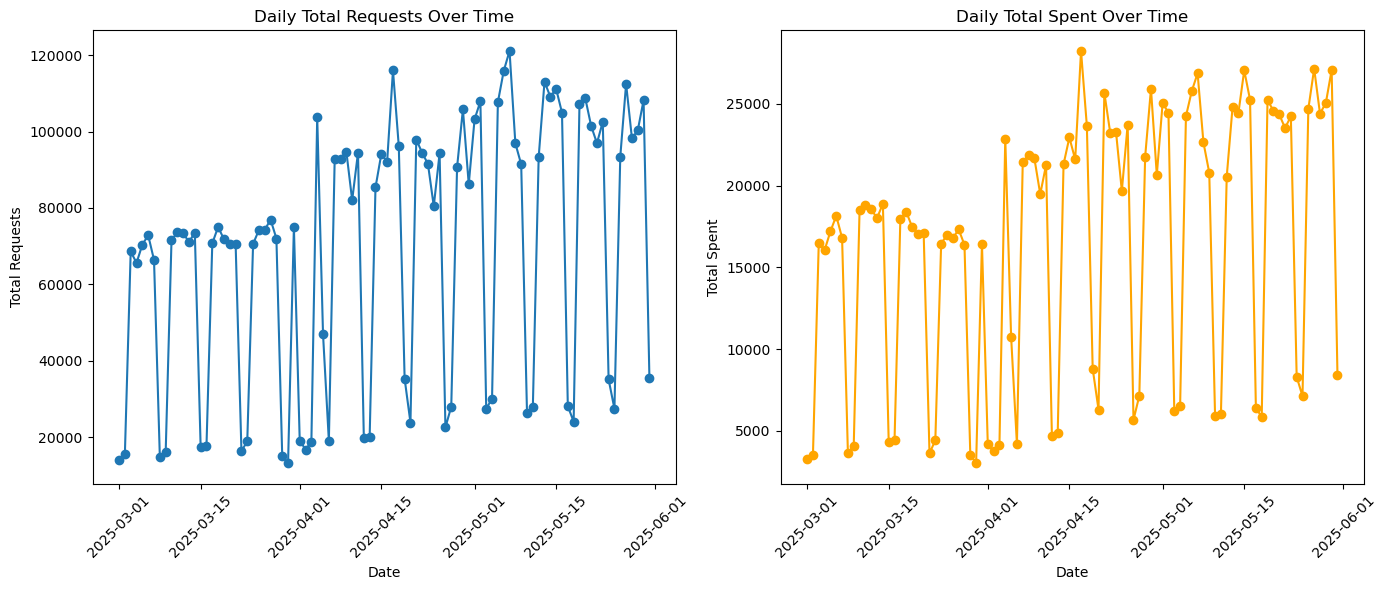

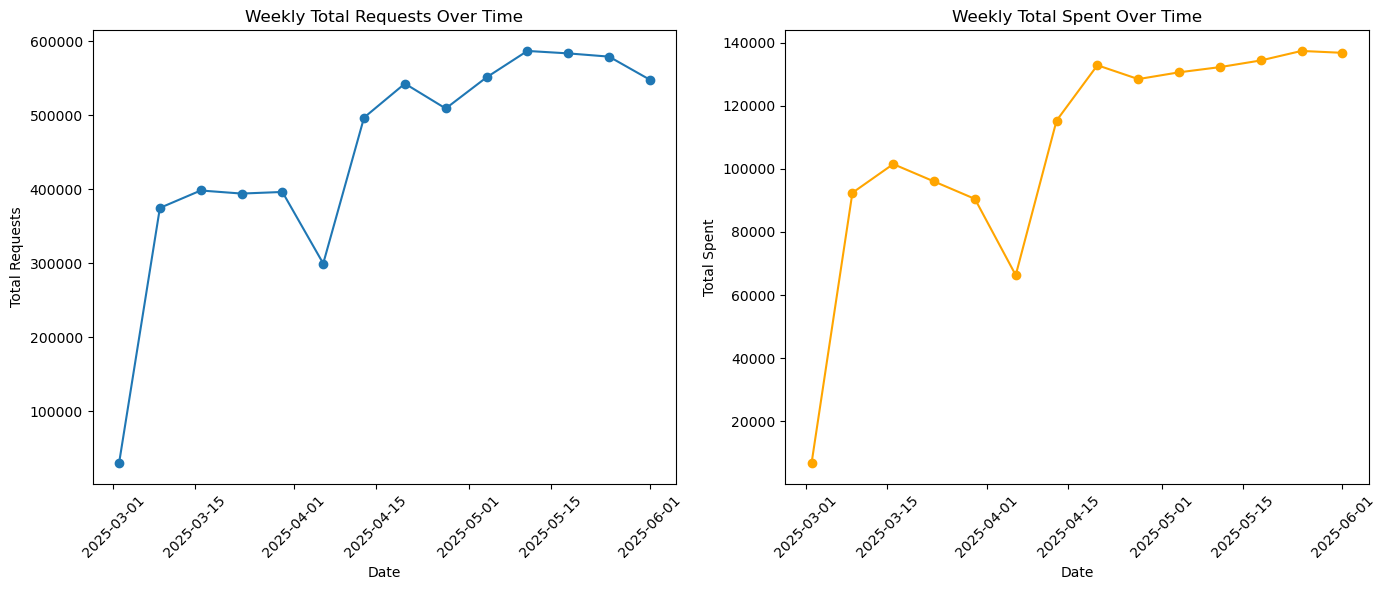

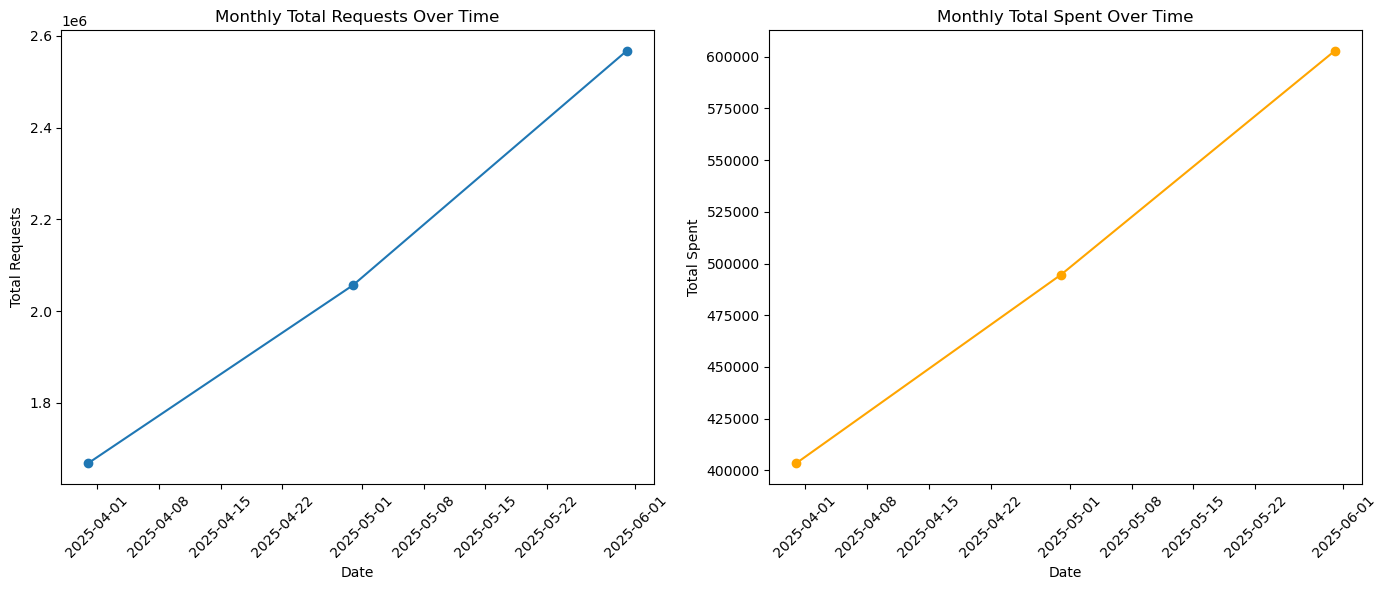

In [33]:
#Aggregate data at daily, weekly, or monthly levels to analyze trends over time and provide different perspectives
df['date'] = pd.to_datetime(df['day_id'], format='%Y-%m-%d')
daily_agg = df.groupby('date').agg(
    total_requests=('requests_cnt', 'sum'),
    total_spent=('spent_amount', 'sum')
).reset_index()
weekly_agg = df.groupby(pd.Grouper(key='date', freq='W')).agg(
    total_requests=('requests_cnt', 'sum'),
    total_spent=('spent_amount', 'sum')
).reset_index()
monthly_agg = df.groupby(pd.Grouper(key='date', freq='M')).agg(
    total_requests=('requests_cnt', 'sum'),
    total_spent=('spent_amount', 'sum')
).reset_index()
print("Daily Aggregation:")
print(daily_agg.head())
print("Weekly Aggregation:")
print(weekly_agg.head())
print("Monthly Aggregation:")
print(monthly_agg.head())

# Visualization of aggregated daily data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(daily_agg['date'], daily_agg['total_requests'], marker='o')
plt.title('Daily Total Requests Over Time')
plt.xlabel('Date')
plt.ylabel('Total Requests')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.plot(daily_agg['date'], daily_agg['total_spent'], marker='o', color='orange')
plt.title('Daily Total Spent Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization of aggregated weekly data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(weekly_agg['date'], weekly_agg['total_requests'], marker='o')
plt.title('Weekly Total Requests Over Time')
plt.xlabel('Date')
plt.ylabel('Total Requests')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.plot(weekly_agg['date'], weekly_agg['total_spent'], marker='o', color='orange')
plt.title('Weekly Total Spent Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization of aggregated monthly data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(monthly_agg['date'], monthly_agg['total_requests'], marker='o')
plt.title('Monthly Total Requests Over Time')
plt.xlabel('Date')
plt.ylabel('Total Requests')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.plot(monthly_agg['date'], monthly_agg['total_spent'], marker='o', color='orange')
plt.title('Monthly Total Spent Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

